In [181]:
import numpy as np
import pandas as pd

In [182]:
import numpy as np
import pandas as pd

# ログ表示
class Log:
    # 表示ログレベル
    Loglevel = 0
    def logLevelset(level):
        # 表示ログレベルの設定
        Log.Loglevel = level
    def log_print(level, std, *variable):
        if(Log.Loglevel >= level):
            if(len(variable) == 0):
                print(std)
            else:
                for i in range(len(variable)):
                    index = std.find("}") + 1
                    # 改行なし表示
                    print(std[:index].format(variable[i]), end='')
                    # 表示した分を削除
                    std = std.replace(std[:index], "", 1)
                # 改行表示
                print(std)

In [200]:
Log.logLevelset(2)

In [201]:
class ScratchDeepNeuralNetrowkRegressor:
    """
    シンプルな三層ニューラルネットワーク分類器

    Parameters
    ----------

    Attributes
    ----------
    """
    def __init__(self, verbose=True, lr=1e-2, num_epoch=100, batch_size=1460, sigma=1e-4, n_nodes1=10, n_nodes2=5, n_output=1):
        self.verbose = verbose
        self.lr = lr
        self.num_epoch = num_epoch # epoch回数
        self.batch_size = batch_size # バッチサイズ
        self.sigma = sigma
        self.n_features = 0
        self.n_nodes1 = n_nodes1 # 1層目のノード数
        self.n_nodes2 = n_nodes2 # 2層目のノード数
        self.n_output = n_output # 出力数（3層目のノード数）
        self.cost = []
        
        # レイヤーのインスタンス
        self.FC1 = None
        self.FC2 = None
        self.FC3 = None
        self.activation1 = None
        self.activation2 = None
        self.activation3 = None
    
    def fit(self, X, y, X_val=None, y_val=None):
        if self.verbose:
            #verboseをTrueにした際は学習過程などを出力する
            print()
        
        # array変換
        X = np.array(X)
        y = np.array(y)
        
        # ミニバッチ生成
        get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size)
                
        """
        初期化処理
        """
        self.n_features = X.shape[1]
        
        optimizer = SGD(self.lr)
        self.FC1 = FC(self.n_features, self.n_nodes1, SimpleInitializer(self.sigma), optimizer)
        self.activation1 = Tanh()
        self.FC2 = FC(self.n_nodes1, self.n_nodes2, SimpleInitializer(self.sigma), optimizer)
        self.activation2 = Tanh()
        self.FC3 = FC(self.n_nodes2, self.n_output, SimpleInitializer(self.sigma), optimizer)
        self.activation3 = Identity()
        
        # エポック数分繰り返す
        for epoch in range(self.num_epoch):
            #print(epoch)
            for i, (mini_X, mini_y) in enumerate(get_mini_batch):
                """
                フォワードプロパゲーション
                """
                A1 = self.FC1.forward(X)
                Z1 = self.activation1.forward(A1)
                A2 = self.FC2.forward(Z1)
                Z2 = self.activation2.forward(A2)
                A3 = self.FC3.forward(Z2)
                Z3 = self.activation3.forward(A3)
                
                """
                フォワードプロパゲーション
                """
                dA3 = self.activation3.backward(Z3, y) # 交差エントロピー誤差とソフトマックスを合わせている
                dZ2 = self.FC3.backward(dA3)
                dA2 = self.activation2.backward(dZ2)
                dZ1 = self.FC2.backward(dA2)
                dA1 = self.activation1.backward(dZ1)
                dZ0 = self.FC1.backward(dA1) # dZ0は使用しない
                
            # 平均二乗誤差
            loss = MSE.calculation(dA3)
            self.cost.append(loss)
            
    def predict(self, X):
        # array変換
        X = np.array(X)
        
        get_mini_batch = GetMiniBatch(X, X, batch_size=10)
        
        for i, (mini_X, mini_y) in enumerate(get_mini_batch):
            A1 = self.FC1.forward(X)
            Z1 = self.activation1.forward(A1)
            A2 = self.FC2.forward(Z1)
            Z2 = self.activation2.forward(A2)
            A3 = self.FC3.forward(Z2)
            Z3 = self.activation3.forward(A3)
            
        return Z3

In [185]:
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = optimizer
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = initializer.W(n_nodes1, n_nodes2)
        Log.log_print(1, "self.W.shape{}", self.W.shape)
        Log.log_print(2, "self.W{}", self.W)
        self.B = initializer.B(n_nodes2)
        Log.log_print(1, "self.B.shape{}", self.B.shape)
        Log.log_print(2, "self.B{}", self.B)   
        self.forward_x = 0
        self.dZ = 0
        self.dA = 0
        
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """
        self.forward_x = X.copy()
        Log.log_print(2, "self.forward_x{}", self.forward_x)
        Log.log_print(1, "self.forward_x.shape{}", self.forward_x.shape)
        A = np.dot(X, self.W) + self.B
        Log.log_print(1, "A.shape{}", A.shape)
        Log.log_print(2, "A{}", A)
        return A
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        Log.log_print(1, "更新前")
        Log.log_print(1, "self.B{}", self.B.shape)
        Log.log_print(1, "self.W{}", self.W.shape)
        
        self.dA = dA
        Log.log_print(1, "self.dA.shape{}", self.dA.shape)
        
        self.dZ = np.dot(dA, self.W.T)
        Log.log_print(1, "self.dZ.shape{}", self.dZ.shape)
        
        Log.log_print(2, "self.dZ{}", self.dZ)
        Log.log_print(1, "self.dZ.shape{}", self.dZ.shape)
        
        # 更新
        #self = self.optimizer.update(self)
        self.optimizer.update(self)
        
        Log.log_print(1, "更新後")
        Log.log_print(1, "self.B{}", self.B.shape)
        Log.log_print(1, "self.W{}", self.W.shape)
        
        return self.dZ

In [186]:
class SimpleInitializer:
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    function : std
      初期関数のモード
    """
    def __init__(self, sigma):
        self.sigma = sigma
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W :
        """
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B :
        """
        B = self.sigma * np.random.randn(1, n_nodes2)
        return B

In [187]:
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス

        Returns
        ----------
        layer : 更新後の層のインスタンス
        """
        layer.W = layer.W - self.lr*np.dot(layer.forward_x.T, layer.dA) / layer.dA.shape[0]
        layer.B = layer.B - self.lr*np.mean(layer.dA, axis=0)[np.newaxis,:]
        
        Log.log_print(1, "layer.W.shape{}", layer.W.shape)
        Log.log_print(2, "layer.W{}", layer.W)
        Log.log_print(1, "layer.B.shape{}", layer.B.shape)
        Log.log_print(2, "layer.B{}", layer.B)
        
        #return layer

In [188]:
class AddGrand:
    """
    最適劣勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
        
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス

        Returns
        ----------
        layer : 更新後の層のインスタンス
        """
        layer.HW = layer.HW + layer.W**2
        layer.HB = layer.HB + np.mean(layer.B**2, axis=0)[np.newaxis,:]
        
        layer.W = layer.W - self.lr*(1/np.sqrt(layer.HW))*np.dot(layer.forward_x.T, layer.dA) / layer.dA.shape[0]
        layer.B = layer.B - self.lr*(1/np.sqrt(layer.HB))*np.mean(layer.dA, axis=0)[np.newaxis,:]
        
        Log.log_print(1, "layer.W.shape{}", layer.W.shape)
        Log.log_print(2, "layer.W{}", layer.W)
        Log.log_print(1, "layer.B.shape{}", layer.B.shape)
        Log.log_print(2, "layer.B{}", layer.B)
        
        #return layer

In [189]:
class Tanh:
    def __init__(self):
        self.A = 0
        
    def forward(self, A):
        self.A = A
        return np.tanh(A)
    
    def backward(self, dZ):
        dA = dZ *(1 - np.tanh(self.A)**2)
        Log.log_print(1, "dA.shape{}", dA.shape)
        Log.log_print(2, "dA{}", dA)
        return dA

In [190]:
class ReLU:
    def __init__(self):
        self.A = 0
        
    def forward(self, A):
        self.A = A
        return np.maximum(A, 0)
    
    def backward(self, dZ):
        A = self.A.copy()
        A[A>0]=1
        A[A<=0]=0
        dA = dZ *A
        Log.log_print(1, "dA.shape{}", dA.shape)
        Log.log_print(2, "dA{}", dA)
        return dA

In [191]:
class Identity:
    def __init__(self):
        pass
    
    def forward(self, A):
        return A
    
    def backward(self, Yhat, Y):
        return Yhat - Y

In [192]:
class MSE:
    @classmethod
    def calculation(self, loss):
        return np.mean((loss)**2) / 2

In [193]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      学習データ
    y : 次の形のndarray, shape (n_samples, 1)または(n_samples,)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード

    Retruns
    ----------
    for文で呼び出すと以下の2つを返す。最後のイテレーションでは、バッチサイズより小さいこともある。
    mini_X : 次の形のndarray, shape (batch_size, n_features)
      学習データのミニバッチ
    mini_y : 次の形のndarray, shape (batch_size, 1)または(batch_size,)
      正解値のミニバッチ
    """
    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        # ランダムに並べ換える
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._counter = 0
        # イテレーション数を計算する
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        # len()が使われたときの処理
        return self._stop

    def __iter__(self):
        return self

    def __next__(self):
        # for文で呼ばれた際のループごとの処理
        if self._counter >= self._stop:
            # 最後まで進んだら終了
            self._counter = 0
            raise StopIteration()

        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]

In [194]:
data = pd.read_csv("./House_Prices/train.csv")
X = data[["GrLivArea", "YearBuilt"]]
y = data[["SalePrice"]]

In [195]:
NW = ScratchDeepNeuralNetrowkRegressor()

In [65]:
NW.fit(X, y)

In [42]:
NW.predict(X)

array([[208500.],
       [181500.],
       [223500.],
       ...,
       [266500.],
       [142125.],
       [147500.]])

In [45]:
y

,SalePrice
0,208500
1,181500
2,223500
3,140000
4,250000
5,143000
6,307000
7,200000
8,129900
9,118000


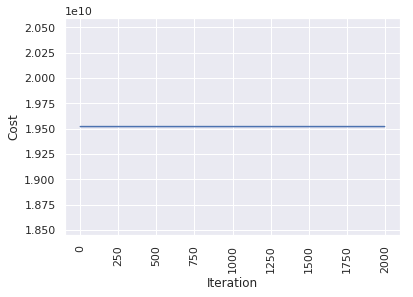

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

plt.plot(NW.cost)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.xticks(rotation="vertical")
plt.show()

In [ ]:
7.07015212e-05
7.06992912e-05
7.06948314e-05

In [202]:
NW2 = ScratchDeepNeuralNetrowkRegressor()
NW2.fit(X, y)


self.W.shape(2, 10)
self.W[[ 1.02256840e-04 -1.47905171e-04  1.90105139e-04 -8.73317724e-05
  -8.18601322e-06  1.17189492e-04 -1.09348814e-06 -3.27425388e-05
   7.31955483e-05 -5.51449180e-05]
 [-7.52133713e-05 -1.06136058e-04  6.75133304e-05  9.13890330e-05
   1.77751719e-04  5.03479124e-05  6.91955581e-07 -3.01307206e-05
  -9.71076399e-06  1.93478628e-05]]
self.B.shape(1, 10)
self.B[[ 5.76733349e-05 -9.45930329e-05 -3.11302987e-05 -5.17311351e-05
   5.56669627e-06  1.89635392e-05 -2.45511846e-04  4.97313271e-05
  -5.05013009e-05  3.86100654e-05]]
self.W.shape(10, 5)
self.W[[-4.65020047e-05  1.19697214e-05  5.22751047e-05  2.54056325e-05
  -2.17701608e-04]
 [ 3.67035539e-05  3.32867440e-05 -4.95868029e-05  9.41143562e-06
   3.82038320e-05]
 [-1.80080112e-04  4.62789703e-05 -1.43008571e-05  2.62254866e-05
   1.00556421e-05]
 [ 1.50065676e-04 -4.74304137e-06 -7.46071191e-05 -1.38334937e-04
  -2.87390509e-05]
 [-1.87314661e-04 -1.00625302e-04 -2.12163514e-05 -1.21710680e-04
   1.5948629

layer.W.shape(2, 10)
layer.W[[ 0.01077682 -0.01581651  0.02983382 -0.05894309  0.02538217  0.06972057
   0.06657586  0.03783129 -0.01140381  0.00900134]
 [ 0.01253485 -0.01907017  0.03620337 -0.06925999  0.0300679   0.08330981
   0.07844831  0.04466067 -0.01358544  0.01070866]]
layer.B.shape(1, 10)
layer.B[[ 6.40478579e-05 -1.04181752e-04 -1.28584586e-05 -8.67886134e-05
   2.06771091e-05  6.10567949e-05 -2.05855743e-04  7.23233215e-05
  -5.73641123e-05  4.40136616e-05]]
更新後
self.B(1, 10)
self.W(2, 10)
self.forward_x[[1710 2003]
 [1262 1976]
 [1786 2001]
 ...
 [2340 1941]
 [1078 1950]
 [1256 1965]]
self.forward_x.shape(1460, 2)
A.shape(1460, 10)
A[[ 43.53572701 -65.24387765 123.53116861 ... 154.14689355 -46.71220498
   36.84176802]
 [ 38.36927269 -57.64318794 109.18812523 ... 135.99263769 -41.23648989
   32.52003523]
 [ 44.32969528 -66.40779186 125.72613238 ... 156.93275024 -47.55172392
   37.50445234]
 ...
 [ 49.54795991 -74.02592672 140.08186796 ... 175.21164481 -53.05431035
   41.848

self.W(10, 5)
dA.shape(1460, 10)
dA[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
更新前
self.B(1, 10)
self.W(2, 10)
self.dA.shape(1460, 10)
self.dZ.shape(1460, 2)
self.dZ[[0. 0.]
 [0. 0.]
 [0. 0.]
 ...
 [0. 0.]
 [0. 0.]
 [0. 0.]]
self.dZ.shape(1460, 2)
layer.W.shape(2, 10)
layer.W[[ 0.01077682 -0.01581651  0.02983382 -0.05894309  0.02538217  0.06972057
   0.06657586  0.03783129 -0.01140381  0.00900134]
 [ 0.01253485 -0.01907017  0.03620337 -0.06925999  0.0300679   0.08330981
   0.07844831  0.04466067 -0.01358544  0.01070866]]
layer.B.shape(1, 10)
layer.B[[ 6.40478579e-05 -1.04181752e-04 -1.28584586e-05 -8.67886134e-05
   2.06771091e-05  6.10567949e-05 -2.05855743e-04  7.23233215e-05
  -5.73641123e-05  4.40136616e-05]]
更新後
self.B(1, 10)
self.W(2, 10)
self.forward_x[[1710 2003]
 [1262 1976]
 [1786 2001]
 ...
 [2340 1941]
 [1078 1950]
 [1256 1965]]
self.forward_x.shape(1460, 2)
A.sha

dA.shape(1460, 5)
dA[[-0. -0.  0.  0.  0.]
 [-0. -0.  0.  0.  0.]
 [-0. -0.  0.  0.  0.]
 ...
 [-0. -0.  0.  0.  0.]
 [-0. -0.  0.  0.  0.]
 [-0. -0.  0.  0.  0.]]
更新前
self.B(1, 5)
self.W(10, 5)
self.dA.shape(1460, 5)
self.dZ.shape(1460, 10)
self.dZ[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
self.dZ.shape(1460, 10)
layer.W.shape(10, 5)
layer.W[[-377.49441765 -224.78074967   36.5404562    30.07556633  242.88035582]
 [ 377.54599243  224.7626084   -36.62500443  -30.07176706 -242.90056178]
 [-377.54532224 -224.76281566   36.62360704   30.07186207  242.90029419]
 [ 377.48725013  224.78332037  -36.52856069  -30.07620988 -242.87777944]
 [-377.53329391 -224.76720579   36.60387294   30.07259244  242.89562757]
 [-377.52829731 -224.76883932   36.59586181   30.07310585  242.89359395]
 [-377.49146577 -224.78179328   36.53559611   30.07561927  242.87941717]
 [-377.47688333 -224.78701835   

self.dZ.shape(1460, 2)
layer.W.shape(2, 10)
layer.W[[ 0.01077682 -0.01581651  0.02983382 -0.05894309  0.02538217  0.06972057
   0.06657586  0.03783129 -0.01140381  0.00900134]
 [ 0.01253485 -0.01907017  0.03620337 -0.06925999  0.0300679   0.08330981
   0.07844831  0.04466067 -0.01358544  0.01070866]]
layer.B.shape(1, 10)
layer.B[[ 6.40478579e-05 -1.04181752e-04 -1.28584586e-05 -8.67886134e-05
   2.06771091e-05  6.10567949e-05 -2.05855743e-04  7.23233215e-05
  -5.73641123e-05  4.40136616e-05]]
更新後
self.B(1, 10)
self.W(2, 10)
self.forward_x[[1710 2003]
 [1262 1976]
 [1786 2001]
 ...
 [2340 1941]
 [1078 1950]
 [1256 1965]]
self.forward_x.shape(1460, 2)
A.shape(1460, 10)
A[[ 43.53572701 -65.24387765 123.53116861 ... 154.14689355 -46.71220498
   36.84176802]
 [ 38.36927269 -57.64318794 109.18812523 ... 135.99263769 -41.23648989
   32.52003523]
 [ 44.32969528 -66.40779186 125.72613238 ... 156.93275024 -47.55172392
   37.50445234]
 ...
 [ 49.54795991 -74.02592672 140.08186796 ... 175.21164481

更新後
self.B(1, 10)
self.W(2, 10)
self.forward_x[[1710 2003]
 [1262 1976]
 [1786 2001]
 ...
 [2340 1941]
 [1078 1950]
 [1256 1965]]
self.forward_x.shape(1460, 2)
A.shape(1460, 10)
A[[ 43.53572701 -65.24387765 123.53116861 ... 154.14689355 -46.71220498
   36.84176802]
 [ 38.36927269 -57.64318794 109.18812523 ... 135.99263769 -41.23648989
   32.52003523]
 [ 44.32969528 -66.40779186 125.72613238 ... 156.93275024 -47.55172392
   37.50445234]
 ...
 [ 49.54795991 -74.02592672 140.08186796 ... 175.21164481 -53.05431035
   41.84867384]
 [ 36.0604325  -54.23712626 102.75741435 ... 127.87050302 -38.78496694
   30.58536413]
 [ 38.16672842 -57.33851705 108.61088526 ... 135.27438262 -41.01862722
   32.34823199]]
self.forward_x[[ 1. -1.  1. ...  1. -1.  1.]
 [ 1. -1.  1. ...  1. -1.  1.]
 [ 1. -1.  1. ...  1. -1.  1.]
 ...
 [ 1. -1.  1. ...  1. -1.  1.]
 [ 1. -1.  1. ...  1. -1.  1.]
 [ 1. -1.  1. ...  1. -1.  1.]]
self.forward_x.shape(1460, 10)
A.shape(1460, 5)
A[[-4152.68496486 -2472.50193764   402.

layer.W.shape(10, 5)
layer.W[[-377.49441765 -224.78074967   36.5404562    30.07556633  242.88035582]
 [ 377.54599243  224.7626084   -36.62500443  -30.07176706 -242.90056178]
 [-377.54532224 -224.76281566   36.62360704   30.07186207  242.90029419]
 [ 377.48725013  224.78332037  -36.52856069  -30.07620988 -242.87777944]
 [-377.53329391 -224.76720579   36.60387294   30.07259244  242.89562757]
 [-377.52829731 -224.76883932   36.59586181   30.07310585  242.89359395]
 [-377.49146577 -224.78179328   36.53559611   30.07561927  242.87941717]
 [-377.47688333 -224.78701835   36.51185259   30.07679303  242.87380068]
 [ 377.47814503  224.78638339  -36.51409358  -30.07668474 -242.87447908]
 [-377.48460348 -224.78444928   36.52428764   30.07613127  242.87681754]]
layer.B.shape(1, 5)
layer.B[[-377.61929359 -224.73675415   36.74528765   30.0664433   242.92923646]]
更新後
self.B(1, 5)
self.W(10, 5)
dA.shape(1460, 10)
dA[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 

layer.W.shape(2, 10)
layer.W[[ 0.01077682 -0.01581651  0.02983382 -0.05894309  0.02538217  0.06972057
   0.06657586  0.03783129 -0.01140381  0.00900134]
 [ 0.01253485 -0.01907017  0.03620337 -0.06925999  0.0300679   0.08330981
   0.07844831  0.04466067 -0.01358544  0.01070866]]
layer.B.shape(1, 10)
layer.B[[ 6.40478579e-05 -1.04181752e-04 -1.28584586e-05 -8.67886134e-05
   2.06771091e-05  6.10567949e-05 -2.05855743e-04  7.23233215e-05
  -5.73641123e-05  4.40136616e-05]]
更新後
self.B(1, 10)
self.W(2, 10)
self.forward_x[[1710 2003]
 [1262 1976]
 [1786 2001]
 ...
 [2340 1941]
 [1078 1950]
 [1256 1965]]
self.forward_x.shape(1460, 2)
A.shape(1460, 10)
A[[ 43.53572701 -65.24387765 123.53116861 ... 154.14689355 -46.71220498
   36.84176802]
 [ 38.36927269 -57.64318794 109.18812523 ... 135.99263769 -41.23648989
   32.52003523]
 [ 44.32969528 -66.40779186 125.72613238 ... 156.93275024 -47.55172392
   37.50445234]
 ...
 [ 49.54795991 -74.02592672 140.08186796 ... 175.21164481 -53.05431035
   41.848

layer.B[[-377.61929359 -224.73675415   36.74528765   30.0664433   242.92923646]]
更新後
self.B(1, 5)
self.W(10, 5)
dA.shape(1460, 10)
dA[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
更新前
self.B(1, 10)
self.W(2, 10)
self.dA.shape(1460, 10)
self.dZ.shape(1460, 2)
self.dZ[[0. 0.]
 [0. 0.]
 [0. 0.]
 ...
 [0. 0.]
 [0. 0.]
 [0. 0.]]
self.dZ.shape(1460, 2)
layer.W.shape(2, 10)
layer.W[[ 0.01077682 -0.01581651  0.02983382 -0.05894309  0.02538217  0.06972057
   0.06657586  0.03783129 -0.01140381  0.00900134]
 [ 0.01253485 -0.01907017  0.03620337 -0.06925999  0.0300679   0.08330981
   0.07844831  0.04466067 -0.01358544  0.01070866]]
layer.B.shape(1, 10)
layer.B[[ 6.40478579e-05 -1.04181752e-04 -1.28584586e-05 -8.67886134e-05
   2.06771091e-05  6.10567949e-05 -2.05855743e-04  7.23233215e-05
  -5.73641123e-05  4.40136616e-05]]
更新後
self.B(1, 10)
self.W(2, 10)
self.forward_x[[1710 2003]
 [1262 1

self.forward_x[[ 1. -1.  1. ...  1. -1.  1.]
 [ 1. -1.  1. ...  1. -1.  1.]
 [ 1. -1.  1. ...  1. -1.  1.]
 ...
 [ 1. -1.  1. ...  1. -1.  1.]
 [ 1. -1.  1. ...  1. -1.  1.]
 [ 1. -1.  1. ...  1. -1.  1.]]
self.forward_x.shape(1460, 10)
A.shape(1460, 5)
A[[-4152.68496486 -2472.50193764   402.34848068   330.81277523
   2671.78196368]
 [-4152.68496486 -2472.50193764   402.34848068   330.81277523
   2671.78196368]
 [-4152.68496486 -2472.50193764   402.34848068   330.81277523
   2671.78196368]
 ...
 [-4152.68496486 -2472.50193764   402.34848068   330.81277523
   2671.78196368]
 [-4152.68496486 -2472.50193764   402.34848068   330.81277523
   2671.78196368]
 [-4152.68496486 -2472.50193764   402.34848068   330.81277523
   2671.78196368]]
self.forward_x[[-1. -1.  1.  1.  1.]
 [-1. -1.  1.  1.  1.]
 [-1. -1.  1.  1.  1.]
 ...
 [-1. -1.  1.  1.  1.]
 [-1. -1.  1.  1.  1.]
 [-1. -1.  1.  1.  1.]]
self.forward_x.shape(1460, 5)
A.shape(1460, 1)
A[[-9588851.37226999]
 [-9588851.37226999]
 [-9588851.

dA.shape(1460, 10)
dA[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
更新前
self.B(1, 10)
self.W(2, 10)
self.dA.shape(1460, 10)
self.dZ.shape(1460, 2)
self.dZ[[0. 0.]
 [0. 0.]
 [0. 0.]
 ...
 [0. 0.]
 [0. 0.]
 [0. 0.]]
self.dZ.shape(1460, 2)
layer.W.shape(2, 10)
layer.W[[ 0.01077682 -0.01581651  0.02983382 -0.05894309  0.02538217  0.06972057
   0.06657586  0.03783129 -0.01140381  0.00900134]
 [ 0.01253485 -0.01907017  0.03620337 -0.06925999  0.0300679   0.08330981
   0.07844831  0.04466067 -0.01358544  0.01070866]]
layer.B.shape(1, 10)
layer.B[[ 6.40478579e-05 -1.04181752e-04 -1.28584586e-05 -8.67886134e-05
   2.06771091e-05  6.10567949e-05 -2.05855743e-04  7.23233215e-05
  -5.73641123e-05  4.40136616e-05]]
更新後
self.B(1, 10)
self.W(2, 10)
self.forward_x[[1710 2003]
 [1262 1976]
 [1786 2001]
 ...
 [2340 1941]
 [1078 1950]
 [1256 1965]]
self.forward_x.shape(1460, 2)
A.shape(1460, 10)
A

layer.W.shape(2, 10)
layer.W[[ 0.01077682 -0.01581651  0.02983382 -0.05894309  0.02538217  0.06972057
   0.06657586  0.03783129 -0.01140381  0.00900134]
 [ 0.01253485 -0.01907017  0.03620337 -0.06925999  0.0300679   0.08330981
   0.07844831  0.04466067 -0.01358544  0.01070866]]
layer.B.shape(1, 10)
layer.B[[ 6.40478579e-05 -1.04181752e-04 -1.28584586e-05 -8.67886134e-05
   2.06771091e-05  6.10567949e-05 -2.05855743e-04  7.23233215e-05
  -5.73641123e-05  4.40136616e-05]]
更新後
self.B(1, 10)
self.W(2, 10)
self.forward_x[[1710 2003]
 [1262 1976]
 [1786 2001]
 ...
 [2340 1941]
 [1078 1950]
 [1256 1965]]
self.forward_x.shape(1460, 2)
A.shape(1460, 10)
A[[ 43.53572701 -65.24387765 123.53116861 ... 154.14689355 -46.71220498
   36.84176802]
 [ 38.36927269 -57.64318794 109.18812523 ... 135.99263769 -41.23648989
   32.52003523]
 [ 44.32969528 -66.40779186 125.72613238 ... 156.93275024 -47.55172392
   37.50445234]
 ...
 [ 49.54795991 -74.02592672 140.08186796 ... 175.21164481 -53.05431035
   41.848

dA.shape(1460, 5)
dA[[-0. -0.  0.  0.  0.]
 [-0. -0.  0.  0.  0.]
 [-0. -0.  0.  0.  0.]
 ...
 [-0. -0.  0.  0.  0.]
 [-0. -0.  0.  0.  0.]
 [-0. -0.  0.  0.  0.]]
更新前
self.B(1, 5)
self.W(10, 5)
self.dA.shape(1460, 5)
self.dZ.shape(1460, 10)
self.dZ[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
self.dZ.shape(1460, 10)
layer.W.shape(10, 5)
layer.W[[-377.49441765 -224.78074967   36.5404562    30.07556633  242.88035582]
 [ 377.54599243  224.7626084   -36.62500443  -30.07176706 -242.90056178]
 [-377.54532224 -224.76281566   36.62360704   30.07186207  242.90029419]
 [ 377.48725013  224.78332037  -36.52856069  -30.07620988 -242.87777944]
 [-377.53329391 -224.76720579   36.60387294   30.07259244  242.89562757]
 [-377.52829731 -224.76883932   36.59586181   30.07310585  242.89359395]
 [-377.49146577 -224.78179328   36.53559611   30.07561927  242.87941717]
 [-377.47688333 -224.78701835   

In [197]:
NW2.cost

[19519633829.064453,
 19519633832.337704,
 19519633835.610947,
 19519633838.884197,
 19519633842.157448,
 19519633845.430695,
 19519633848.703945,
 19519633851.97719,
 19519633855.25044,
 19519633858.523685,
 19519633861.796932,
 19519633865.070183,
 19519633868.343433,
 19519633871.61668,
 19519633874.889927,
 19519633878.163174,
 19519633881.436424,
 19519633884.70967,
 19519633887.982918,
 19519633891.25617,
 19519633894.529415,
 19519633897.802666,
 19519633901.07591,
 19519633904.34916,
 19519633907.62241,
 19519633910.895657,
 19519633914.168903,
 19519633917.442154,
 19519633920.7154,
 19519633923.98865,
 19519633927.261894,
 19519633930.535145,
 19519633933.80839,
 19519633937.081642,
 19519633940.354893,
 19519633943.62814,
 19519633946.901386,
 19519633950.174637,
 19519633953.447884,
 19519633956.72113,
 19519633959.994377,
 19519633963.267628,
 19519633966.54088,
 19519633969.814125,
 19519633973.08737,
 19519633976.360622,
 19519633979.633865,
 19519633982.907116,
 1951963

In [198]:
NW2.predict(X)

array([[-0.00167203],
       [-0.00167203],
       [-0.00167203],
       ...,
       [-0.00167204],
       [-0.00167203],
       [-0.00167203]])

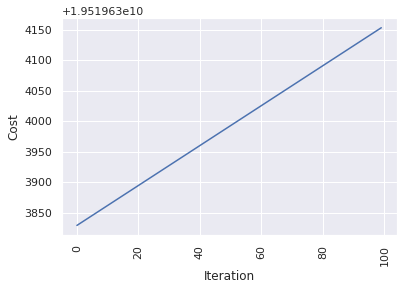

In [199]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

plt.plot(NW2.cost)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.xticks(rotation="vertical")
plt.show()